In this report, we present the **Tabular method**  to address the WindyGridWorld problem. The result demonstrates that our proposed method successfully solve the problem. To shed light on its intricacies, we will delve into their underpinning logics and illustrate how it can be harnessed to tackle the problem. In addition, we further tweak the environment to perform several experiments that serve to test the robustness and accuracy of our model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import gym
import numpy as np
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

### Initialization of the environments

In [3]:
# Building the environment using Gym
class WindyGridWorldEnv(gym.Env):
    """
    This class describes the environment of Windy GridWorld.
    The environment is a rectangular grid with the dimensions 10x8.
    """
    def __init__(self, grid_height=7, grid_width=10, start_state=(3,0), goal_state=(3,7), wind=[0, 0, 0, 1, 1, 1, 2, 2, 1, 0]):
        self.grid_height = grid_height
        self.grid_width = grid_width
        self.start_state = start_state
        self.goal_state = goal_state
        self.wind = wind  # Wind strength for each column.
        # Here, we define the wind direction which is vertical, changing the agent's horizontal coordinate.
        # The distinction between 1 and 2 is indicative of wind strength i.e., displacement distance in the vertical direction.
        # Wind direction impacts the vertical coordinate which can lead to two outcomes:
        # 1. The value is zero, preventing negative numbers.
        # 2. The row number decreases according to the wind strength at the agent's current column, not going below zero.
        # Meanwhile, the horizontal coordinate remains constant.
        self.current_state = self.start_state
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Discrete(self.grid_height * self.grid_width)

    def reset(self):
        """
        This method resets the environment to the starting state.
        """
        self.current_state = self.start_state
        return self._state_to_observation(self.current_state)

    def step(self, action):
        """
        This method performs the given action in the environment.
        Actions include moving up, down, left, right or diagonally.
        """

        if action == 0:  # Up
            self.current_state = (max(0, self.current_state[0] - 1), self.current_state[1])
        elif action == 1:  # Down
            self.current_state = (min(self.grid_height - 1, self.current_state[0] + 1), self.current_state[1])
        elif action == 2:  # Left
            self.current_state = (self.current_state[0], max(0, self.current_state[1] - 1))
        elif action == 3:  # Right
            self.current_state = (self.current_state[0], min(self.grid_width - 1, self.current_state[1] + 1))
        elif action == 4:  # Left-Up
            self.current_state = (max(0, self.current_state[0] - 1), max(0, self.current_state[1] - 1))
        elif action == 5:  # Left-Down
            self.current_state = (min(self.grid_height - 1, self.current_state[0] + 1), max(0, self.current_state[1] - 1))
        elif action == 6:  # Right-Up
            self.current_state = (max(0, self.current_state[0] - 1), min(self.grid_width - 1, self.current_state[1] + 1))
        elif action == 7:  # Right-Down
            self.current_state = (min(self.grid_height - 1, self.current_state[0] + 1), min(self.grid_width - 1, self.current_state[1] + 1))

        self.current_state = (max(0, self.current_state[0] - self.wind[self.current_state[1]]), self.current_state[1])


        if self.current_state == self.goal_state:
            return self._state_to_observation(self.current_state), 10, True, {}

        return self._state_to_observation(self.current_state), -1, False, {}

    def _state_to_observation(self, state):
        """
        This method converts state to observation.
        """
        return state[0] * self.grid_width + state[1]

    def _observation_to_state(self, observation):
        """
        This method converts observation to state.
        """
        return (observation // self.grid_width, observation % self.grid_width)

    def render(self, mode='human', close=False):
        """
        This method renders the environment.
        The code was borrowed and modified from:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py
        """
        plt.figure(figsize=(5, 5))
        for i in range(self.grid_height):
            for j in range(self.grid_width):
                position = (i, j)
                if self.current_state == position:
                    marker = 'yo'
                elif position == self.goal_state:
                    marker = 'go'
                elif position == self.start_state:
                    marker = 'bo'
                else:
                    marker = 'wo'

                plt.plot(j, self.grid_height - 1 - i, marker)

        # Draw wind
                if self.wind[j] != 0:
                    plt.arrow(j, self.grid_height - 1 - i, 0, self.wind[j]/4.0, head_width=0.1, head_length=0.1, fc='r', ec='r')

        plt.xlim([-0.5, self.grid_width - 0.5])
        plt.ylim([-0.5, self.grid_height - 0.5])
        plt.xticks(range(self.grid_width))
        plt.yticks(range(self.grid_height))
        plt.grid(True)
        plt.title("Windy GridWorld")
        plt.pause(0.1)
        
def convert_action(action_list):
    action_list_word = []
    for i in action_list:
        if i == 0:  # Up
            action_list_word.append('Up')
        elif i == 1:  # Down
            action_list_word.append('Down')
        elif i == 2:  # Left
            action_list_word.append('Left')
        elif i == 3:  # Right
            action_list_word.append('Right')
        elif i == 4:  # Left-Up
            action_list_word.append('Left-Up')
        elif i == 5:  # Left-Down
            action_list_word.append('Left-Down')
        elif i == 6:  # Right-Up
            action_list_word.append('Right-Up')
        elif i == 7:  # Right-Down
            action_list_word.append('Right-Down')
    return action_list_word

In [4]:
env = WindyGridWorldEnv()

**Environment**: The environment we have created above provides a comprehensive setting for the Windy GridWorld problem. This environment, comprising a 10x7 grid, exhibits varying wind strengths across each column. Notably, the wind direction in this environment is vertical, which implies that the agent's row number will be shifted upwards in columns with wind, depending on the wind's strength.

**State**: The agent's state is represented by its current location, expressed in the form of a tuple (row, column). In our context, the agent's initial position is located at the fourth row and the first column, represented as (3,0) in the above code. The target, meanwhile, is located at (3,7).

**Action**: We have defined eight possible actions: up, down, left, right, upper-left, upper-right, lower-left, and lower-right. These actions allow the agent to navigate through the environment in an unrestricted manner.

**Observation**: We defined a _state_to_observation function to obtain the observations from states. The observation is defined as an integer from 0 to 69, which corresponds to each state coordinate. 


**Reward**: Reward is set as -1 in all state transitions except 10 scores for arriving at the goal state. 

In [5]:
# Create a class to animate the GridWorld
class GridWorldAnimation:
    def __init__(self, env, frames):
        self.env = env
        self.frames = frames

    def _render_frame(self, frame):
        # Draw the current state of the environment
        env = self.env
        plt.cla()
        for i in range(env.grid_height):
            for j in range(env.grid_width):
                position = (i, j)
                if frame == position:
                    marker = 'yo'
                elif position == env.goal_state:
                    marker = 'go'
                elif position == env.start_state:
                    marker = 'bo'
                else:
                    marker = 'wo'
                plt.plot(j, env.grid_height - 1 - i, marker)


                if env.wind[j] != 0:
                        plt.arrow(j, env.grid_height - 1 - i, 0, env.wind[j]/4.0, head_width=0.1, head_length=0.1, fc='r', ec='r')
                        
        plt.xlim([-0.5, env.grid_width - 0.5])
        plt.ylim([-0.5, env.grid_height - 0.5])
        plt.xticks(range(env.grid_width))
        plt.yticks(range(env.grid_height))
        plt.grid(True)
        plt.title("Windy GridWorld")

    def animate(self, i):
        # Animate a single frame
        self._render_frame(self.frames[i])

    def display(self):
        # Create animation and display
        fig = plt.figure(figsize=(5, 5))
        ani = animation.FuncAnimation(fig, self.animate, frames=len(self.frames), repeat=False)
        return HTML(ani.to_jshtml())

### Visualization of the environment

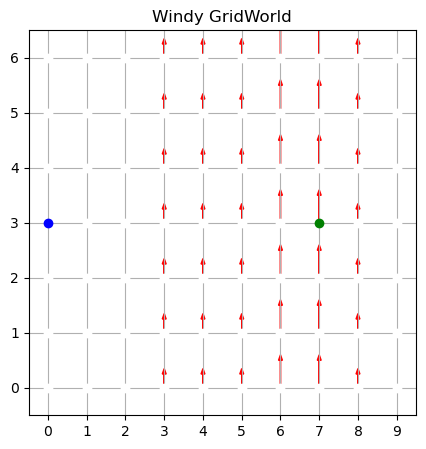

In [6]:
env = WindyGridWorldEnv()
# We are creating a new figure of size 5x5
plt.figure(figsize=(5, 5))

# Create grid
for i in range(env.grid_height):
    for j in range(env.grid_width):
        position = (i, j)
        # Mark the goal state with a green circle
        if position == env.goal_state:
            marker = 'go'
        # Mark the start state with a blue circle
        elif position == env.start_state:
            marker = 'bo'
        # Mark all other states with a white circle
        else:
            marker = 'wo'
        
        plt.plot(j, env.grid_height - 1 - i, marker)
        # Represent wind with a red arrow
        if env.wind[j] != 0:
            plt.arrow(j, env.grid_height - 1 - i, 0, env.wind[j]/4.0, head_width=0.1, head_length=0.1, fc='r', ec='r')

# Set the limits and x,y- axises of the plot
plt.xlim([-0.5, env.grid_width - 0.5])
plt.ylim([-0.5, env.grid_height - 0.5])
plt.xticks(range(env.grid_width))
plt.yticks(range(env.grid_height))
# Display gridlines
plt.grid(True)
plt.title("Windy GridWorld")
# Display the plot
plt.show()

The visualization above illustrates our Windy GridWorld environment. The starting point of the agent is denoted by the blue dot, and the terminating (or goal) state is indicated by the green dot. We can observe the presence of wind between the 3rd and 8th columns. Particularly, the wind is stronger (symbolized by longer red arrows) in the 6th and 7th columns. As the agent moves through these windy areas, its vertical position will be adjusted based on the strength of the wind. This adjustment, in effect, alters the agent's planned path, making the journey towards the goal state more challenging.

### Tabular Reinforcement Learning Methods

In [7]:
def train_Q_learning(env, num_episodes=1000,max_steps_per_episode=2000,learning_rate=0.05, discount_factor=0.90,
            exploration_rate=1,max_exploration_rate=1.0,min_exploration_rate=0.01,exploration_decay_rate=0.01):
    
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    q_table = np.zeros((num_states, num_actions))
    
    # Keep track of metrics
    average_rewards = []
    average_steps = []

    # Implement the Q-learning algorithm (A posiible solution based on off-policy)
    for episode in range(num_episodes):
        # Reset the environment for each episode
        state = env.reset()
        done = False
        total_reward = 0
        total_steps = 0

        for step in range(max_steps_per_episode):
            # Exploration-exploitation trade-off
            exploration_rate_threshold = np.random.uniform(0, 1)
            if exploration_rate_threshold > exploration_rate:
                # Choose the action with the highest Q-value for this state
                action = np.argmax(q_table[state, :])
            else:
                # Choose a random action
                action = env.action_space.sample()

            # Execute the action and get the new state, reward, and whether the episode is finished
            new_state, reward, done, _ = env.step(action)

            # Update Q-table using the Q-learning update rule
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + \
                                     learning_rate * (reward + discount_factor * np.max(q_table[new_state, :]))

            # Move to the new state
            state = new_state

            # Add the reward to the total reward
            total_reward += reward
            total_steps += 1

            # If the episode is done, break out of the loop
            if done:
                break

        # Decay exploration rate to reduce exploration as the agent learns more about the environment
        exploration_rate = min_exploration_rate + \
                           (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)

        # Track average rewards and steps
        average_rewards.append(total_reward / total_steps)
        average_steps.append(total_steps)
    return q_table, average_rewards, average_steps

In [8]:
# Create the Windy GridWorld environment
env = WindyGridWorldEnv()

In [9]:
q_table, average_rewards, average_steps = train_Q_learning(env)

In [10]:
def play(q_table, average_rewards, average_steps):
    action_list = []
    action_list_word = []

    # print(q_table)
    # Print out the optimal path
    state = env.reset()
    done = False
    frames = [env.current_state]  # Add the initial state to frames
    print("Optimal Path:")
    count = 0

    while not done:
        # Choose the action with the highest Q-value for the current state
        action = np.argmax(q_table[state, :])
        action_list.append(action)
        # Perform the action and get the new state and whether the episode is finished
        new_state, reward, done, _ = env.step(action)
        frames.append(env.current_state)
        state = new_state
        count += 1


    action_list_word = convert_action(action_list)
    # Print the total steps it took for the agent to reach the goal
    print(f"It takes {count} steps to reach the goal.")
    print(action_list_word)

    anim = GridWorldAnimation(env, frames)
    return anim

Optimal Path:
It takes 7 steps to reach the goal.
['Right-Down', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down']


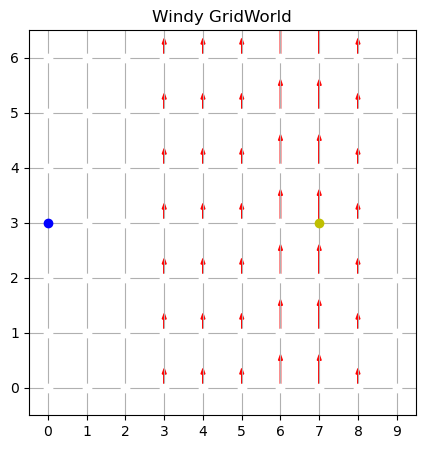

In [11]:
anim = play(q_table, average_rewards, average_steps)
anim.display()

#### Hyperparameter setting:

number of episode: 1000

maximum step number per episode: 2000

learning_rate = 0.05

discount_factor = 0.90

***This is an implementation of an agent trained in the WindyGridWorld environment using Q-learning***

The preceding code segment implements the Q-learning solution for WindyGridWorld. As previously discussed, the agent's objective is to identify the shortest path to the target. To achieve this, the agent must interact with the environment and select an action at each state.

The Q-table, which stores the values of state-action pairs, is the cornerstone of Q-learning. These values, derived from the agent-environment interactions, guide the agent in formulating an optimal policy (the shortest path to the goal).

In our implementation, the Q-table is initially populated with zeroes, and the values for state-action pairs are updated with each iteration. Notably, we establish an **exploration rate threshold** during the iteration to enable the agent to discover potential optimal paths (akin to the epsilon-greedy approach). In essence, if this threshold exceeds the **exploration rate**, a random action is selected. The **exploration rate** is initially set to 1 and decays as the iteration deepens. This is because, in the later stages of Q-learning, when the actions are nearly optimal, exploration becomes redundant. Ultimately, we can derive the optimal path using the Q-table post-iteration.

We also present the corresponding action list following the iteration.

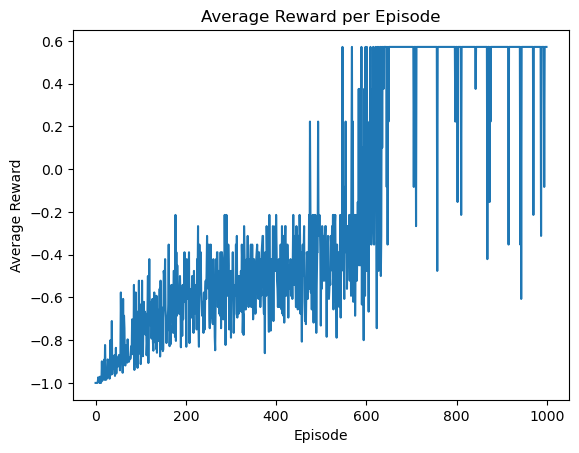

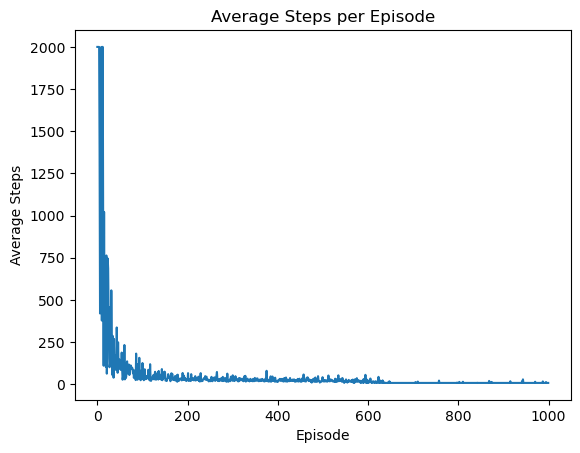

In [12]:
# Plot average rewards
plt.figure()
plt.plot(range(1000), average_rewards)
plt.title("Average Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.show()

# Plot average steps
plt.figure()
plt.plot(range(1000), average_steps)
plt.title("Average Steps per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Steps")
plt.show()

The two plots above depict the average reward and the number of steps taken for each episode. When examining the average reward, we observe a consistent decrease in its value as the iterations progress. This reduction in reward is also reflected in the average steps taken by the agent.

Initially, the agent requires nearly the maximum number of steps to reach the goal. However, as it continues to interact with the environment, it gradually becomes more proficient and efficient in its decision-making process. Consequently, the number of steps taken per iteration decreases over time. Eventually, this number approaches zero, indicating that the agent has learned an optimal strategy to reach the goal.

-----------------------------------------------------------------------------------------------------------------------------------------

### Experiment

To assess the effectiveness of our solution in the modified WindyGridWorld environment, we conducted two experiments. The purpose was to determine if our agent could still achieve an optimal solution after the environment was expanded.

#### Experiment 1：Greater environment with similar starting point and goal point

We increased the size of the environment while ensuring that the starting point and goal remained on the same horizontal line. Specifically, we extended the rows and columns of the environment while keeping the starting point and goal at the central row of the entire expanded grid. The objective was to observe whether the agent could adapt to the larger space and still find an optimal solution.

#### 12 x 12 environment

In [13]:
env = WindyGridWorldEnv(grid_height = 12,
        grid_width = 12,
        start_state = (6, 0),
        goal_state = (6, 8),
        wind = [0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 0, 0])

In [14]:
q_table, average_rewards, average_steps = train_Q_learning(env)

Optimal Path:
It takes 8 steps to reach the goal.
['Right-Down', 'Right', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down']


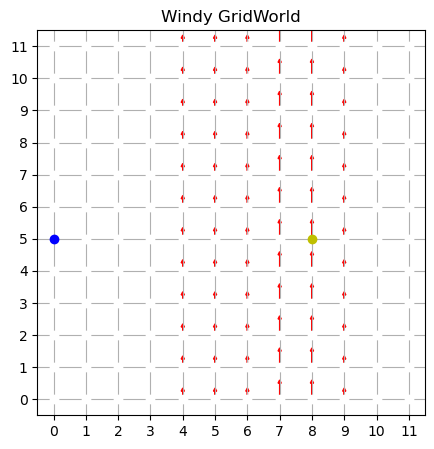

In [15]:
anim = play(q_table, average_rewards, average_steps)
anim.display()

We can see that even if the initial location and destination changes, our implemented solution can also find the optimal solution.

#### Experiment 2: Different starting points with same environment 

#### Experiment2(a): Start point (0,0) Goal point (3,7)

In this experiment, we aimed to test the adaptability of our agent by changing the starting point and goal point in the previous size of the environment (10 x 7). The objective was to verify whether the agent could still generate correct paths under different circumstances.

In [16]:
env = WindyGridWorldEnv(start_state=(0, 0),
                        goal_state=(3, 7))

In [17]:
q_table, average_rewards, average_steps = train_Q_learning(env, 
                                                           num_episodes=100000, 
                                                           learning_rate=0.0005)

Optimal Path:
It takes 10 steps to reach the goal.
['Right-Down', 'Right-Down', 'Down', 'Down', 'Down', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down']


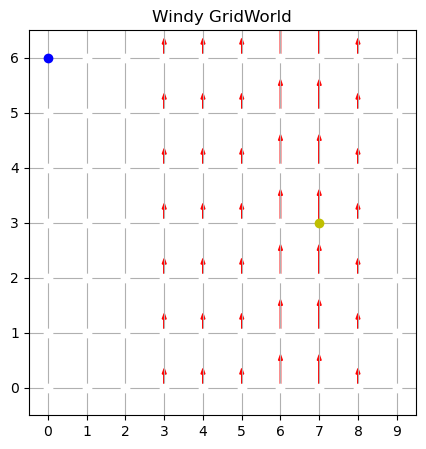

In [18]:
anim = play(q_table, average_rewards, average_steps)
anim.display()

#### Experiment2(b): Start point (6,0) Goal point (3,7)

In [19]:
env = WindyGridWorldEnv(grid_height=7,
                        grid_width=10,
                        start_state=(6, 0),
                        goal_state=(3, 7))

In [20]:
q_table, average_rewards, average_steps = train_Q_learning(env, 
                                                           num_episodes=100000, 
                                                           learning_rate=0.0005)

Optimal Path:
It takes 7 steps to reach the goal.
['Right', 'Right', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down', 'Right-Down']


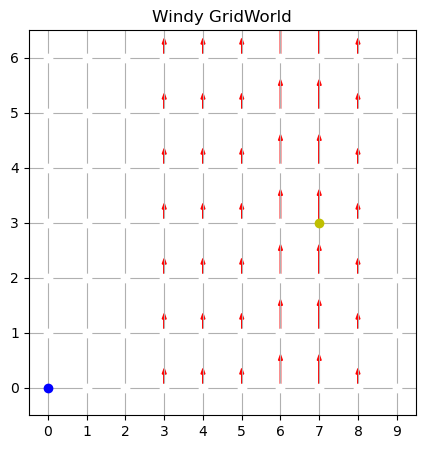

In [21]:
anim = play(q_table, average_rewards, average_steps)
anim.display()

#### Comparison Table for experiment 2

In [23]:
data = {
    'Starting Point': ['(0,0)', '(6,0)'],'Position':['Bottom','Top'],
    'Steps': [10,7]
}


df = pd.DataFrame(data)

markdown_table = df.to_markdown()


print(markdown_table)

|    | Starting Point   | Position   |   Steps |
|---:|:-----------------|:-----------|--------:|
|  0 | (0,0)            | Bottom     |      10 |
|  1 | (6,0)            | Top        |       7 |


### Discussion

We discuss some of our findings in this entire work.

1. In the WindyGridWorld environment, we employ the tabular method, specifically Q-learning. Here, an agent utilizes a table (represented as a NumPy array) to store Q values for each state-action pair. The agent then interacts with the environment, performing actions and updating its Q table based on the rewards and new states received. This iterative process unfolds over multiple rounds, allowing the agent to learn and refine its policy, which dictates the action to take in each state.

    We can gauge the agent's performance in the environment at the end of each round by observing metrics such as the number of steps needed to reach the goal or the reward earned in a round. As the learning process continues, we anticipate an improvement in the agent's performance, manifested as a decrease in the number of steps needed and an increase in the rewards received. In the WindyGridWorld scenario, each step incurs a penalty denoted as -1.

2. In reinforcement learning, the reward's nature (positive or negative) and the sum of the rewards (total_reward) are largely task-dependent. Some tasks may offer positive rewards for correct actions, while others may impose negative rewards for incorrect actions or to incentivize quicker task completion.

    In our Windy GridWorld environment, we assign a negative reward (e.g., -1) for each step taken. This setup encourages the agent to reach the goal as quickly as possible: each step incurs a negative reward, motivating the agent to identify the shortest path to minimize the total reward's negative value.

    Consequently, a negative total_reward does not necessarily indicate poor agent performance or ineffective strategy learning. Instead, as the learning process unfolds, you should expect to see a gradual decrease in the absolute value of total_reward. This trend signifies that the agent is learning to reach the goal more efficiently.

3. In addition to solving the problem, we conducted two supplementary experiments to investigate and validate our suspicions.

    The first suspicion pertained to the robustness of our solution when applied to larger environments while maintaining the same relative position of the agent. The relative position refers to the distance between the starting point and the goal point, as well as their positions on the board. To verify this, we designed experiment 1, where we tested the agent's performance in a larger environment with the same relative position. The results revealed that the path chosen by the agent remained unchanged from the previous implementation. Based on these findings, we concluded that our current solution is correct and robust enough to solve the problem even when the size of the environment increases.

    The second suspicion focused on the impact of the starting point of the agent within the WindyGridWorld setting. In this environment, the wind blows from bottom to top, enabling the agent to utilize it to move more efficiently in the vertical direction while in the wind zone. We hypothesized that starting at the bottom of the world, where the agent could leverage the wind more effectively, would result in fewer steps required to reach the goal. To test this, we conducted an experiment with two initial positions: one at the top and one at the bottom of the world. By comparing the results between these starting points, we observed that starting at the bottom indeed led to fewer steps to reach the goal. Conversely, when the agent started at the top, it had to traverse the wind zone, reach a position below the goal, and then utilize the wind to move upwards, resulting in a larger number of steps.

    Through these experiments, we gained valuable insights and evidence to support our suspicions and conclusions. They provided a deeper understanding of the agent's behavior and performance in different scenarios, reinforcing the effectiveness of our solution and shedding light on the impact of the starting point within the WindyGridWorld environment.